Initial test of LSTM range prediction, based off: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/ 

In [1]:
# Version History:

#------------------------------------------------------------------------------#
#                                                                              #
# v1.0.0 - Testing code to predict range of values.                            #
#                                                                              #
#------------------------------------------------------------------------------#

In [2]:
import pandas
import matplotlib.pyplot as plt
import numpy
from numpy import array
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


Simply showing the original dataset.

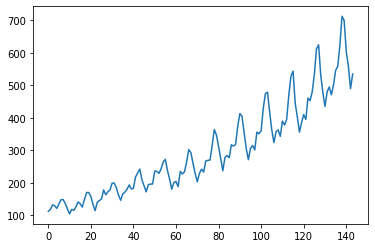

In [3]:
dataset = pandas.read_csv('airline-passengers_v2.csv', usecols=[1], engine='python')
plt.plot(dataset)
plt.show()

Preparing the data for predicting multiple steps into the future.

In [4]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # Finding the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        
        # Checking if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
            
        # Gather input and output parts of pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix: out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [5]:
test = [10, 20, 30, 40, 50, 60, 70, 80, 90]
X, y = split_sequence(test, 3, 2)
for i in range(len(X)):
    print(X[i], y[i])

[10 20 30] [40 50]
[20 30 40] [50 60]
[30 40 50] [60 70]
[40 50 60] [70 80]
[50 60 70] [80 90]


In [6]:
print(dataset)
print(type(dataset))
test_array = dataset.values
array_list = test_array.tolist()

     Passengers
0           112
1           118
2           132
3           129
4           121
..          ...
139         700
140         604
141         559
142         490
143         535

[144 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>


In [7]:
X_test, y_test = split_sequence(array_list, 8, 4)

In [8]:
print(X_test[1], "a", y_test[1])

[[118]
 [132]
 [129]
 [121]
 [135]
 [148]
 [148]
 [136]] a [[119]
 [104]
 [118]
 [115]]


Beginning the preparation for LSTM.

In [9]:
# Fix random seed for reproducibility
numpy.random.seed(7)

# Load the dataset
dataframe = pandas.read_csv('airline-passengers_v2.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
#print(type(dataset))

# Convert dataset into array, then list, then split
#dataset_array = dataset.values
#dataset_list = dataset.tolist()
n_steps_in, n_steps_out = 8, 4
X_dataset, y_dataset = split_sequence(dataset, n_steps_in, n_steps_out)

In [10]:
print(type(X_dataset), type(y_dataset))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [11]:
n_features = 1
y_dataset = y_dataset.reshape((y_dataset.shape[0], y_dataset.shape[1]))
print(X_dataset.shape, y_dataset.shape)

(133, 8, 1) (133, 4)


In [12]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu', return_sequences=False))
#model.add(Flatten())
model.add(Dense(n_steps_out))
model.compile(loss='mse', optimizer='adam')

In [13]:
print(n_steps_in, n_features)

8 1


In [14]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8, 100)            40800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 121,604
Trainable params: 121,604
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
model.fit(X_dataset, y_dataset, epochs=50, verbose=0)
print("All done!")

All done!


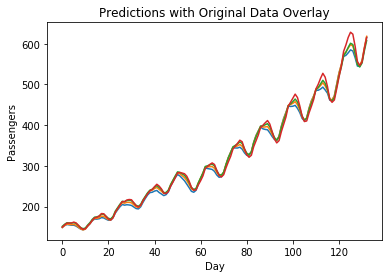

In [21]:
y_dataset_hat = model.predict(X_dataset)
y_dataset_hat = scaler.inverse_transform(y_dataset_hat)
X_plot = X_dataset.reshape(X_dataset.shape[0], X_dataset.shape[1])
X_plot = scaler.inverse_transform(X_plot)
plt.plot(y_dataset_hat)
plt.xlabel('Day')
plt.ylabel('Passengers')
plt.title('Predictions with Original Data Overlay')
#plt.plot(X_plot)
plt.savefig('range_prediction.png')


In [17]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions, to ensure performance is in the same units as original data
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

NameError: name 'trainX' is not defined

Plotting predictions.

In [ ]:
# Shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.savefig('overlay_airline_v2.png')
plt.show()
